In [1]:
import sys, os, cv2, json
import seaborn as sns
import pandas as pd, numpy as np, datetime as dt, matplotlib.pyplot as plt, pytz
from tqdm import tqdm
from itertools import combinations
import matplotlib.lines as mlines

In [2]:
import scienceplots
import matplotlib.ticker as ticker
plt.style.use(['science'])
FIG_WIDTH = 7.5  # width of figure in inches (a4 width)
TARGET_FOLDER = "/home/masc12/dev/masc12-mthesis/eda/img-eda/plots"

In [3]:
from astral.sun import sun # https://astral.readthedocs.io/en/latest/
from astral import LocationInfo
stgallen_city = LocationInfo('St. Gallen', 'Switzerland', 'Europe/Zurich', 47.424492554512014, 9.376722938498643)

In [4]:
webcams = ['altenrhein', 'ebenalp', 'golfclub-erlen', 'kronberg', 'romanshorn', 'rorschacherberg', 'sitterdorf', 'wiler-turm']
wbc_cmap = json.loads(open('webcam_colormap.json').read())

In [ ]:
df_all_images = pd.DataFrame()
for wbc in webcams:
    img_files = os.listdir(f"../../data/{wbc}")
    img_ts = [dt.datetime.strptime(img.split(".")[0], "%Y-%m-%d_%H-%M-%S") for img in img_files]
    img_ts = [pytz.timezone('Europe/Zurich').localize(ts) for ts in img_ts]
    img_files = pd.DataFrame({"filename": img_files, "timestamp": img_ts, "webcam": wbc})
    img_files.sort_values("timestamp", inplace=True)
    img_files.reset_index(drop=True, inplace=True)
    df_all_images = pd.concat([df_all_images, img_files])

# Calculate earliest/latest image start/end

In [7]:
def  get_date_range_from(start, end):
    daterange = []
    while start <= end:
        daterange.append(start)
        start += dt.timedelta(minutes=10)
    return daterange

In [8]:
earliest_img_start = df_all_images.groupby("webcam")["timestamp"].min().min()
latest_img_end     = df_all_images.groupby("webcam")["timestamp"].max().max()
earliest_img_start, latest_img_end

(Timestamp('2024-02-12 08:00:00+0100', tz='Europe/Zurich'),
 Timestamp('2025-03-14 15:10:00+0100', tz='Europe/Zurich'))

In [9]:
latest_img_start = df_all_images.groupby("webcam")["timestamp"].min().max()
earliest_img_end = df_all_images.groupby("webcam")["timestamp"].max().min()
latest_img_start, earliest_img_end

(Timestamp('2024-09-19 14:10:00+0200', tz='Europe/Zurich'),
 Timestamp('2025-03-14 12:10:00+0100', tz='Europe/Zurich'))

In [10]:
common_range_10min = get_date_range_from(latest_img_start, earliest_img_end)
total_range_10min = get_date_range_from(earliest_img_start, latest_img_end)

# Filter by Sunset/Sunrise

In [11]:
fetch_sun_times = lambda date: sun(stgallen_city.observer, date, tzinfo=stgallen_city.timezone)

In [12]:
def filter_dusk_dawn(daterange):
    new = []
    for x in daterange:
        sun_times = fetch_sun_times(x)
        if sun_times['dawn'] <= x <= sun_times['dusk']:
            new.append(x)
    return new

In [13]:
common_filtered_range_10min = filter_dusk_dawn(common_range_10min)
total_filtered_range_10min = filter_dusk_dawn(total_range_10min)

In [14]:
df_common = df_all_images[df_all_images["timestamp"].isin(common_filtered_range_10min)]
df_total = df_all_images[df_all_images["timestamp"].isin(total_filtered_range_10min)]

In [15]:
print(f"{len(df_all_images)} total images.")
print(f"{len(df_total)} total images during daylight hours (dawn to dusk)")
print(f"{len(df_common)} common images (all webcams have images in this interval)")

142123 total images.
119362 total images during daylight hours (dawn to dusk)
82864 common images (all webcams have images in this interval)


In [16]:
total_range_daily = pd.date_range(
    earliest_img_start,
    latest_img_end
)

dusk_dawn_df = pd.DataFrame({
    "ts": [x.date() for x in total_range_daily],
    "dusk": [pd.to_datetime(fetch_sun_times(x)["dusk"]) for x in total_range_daily],
    "dawn": [pd.to_datetime(fetch_sun_times(x)["dawn"]) for x in total_range_daily]
})

# All, Common, Total Disambiguation

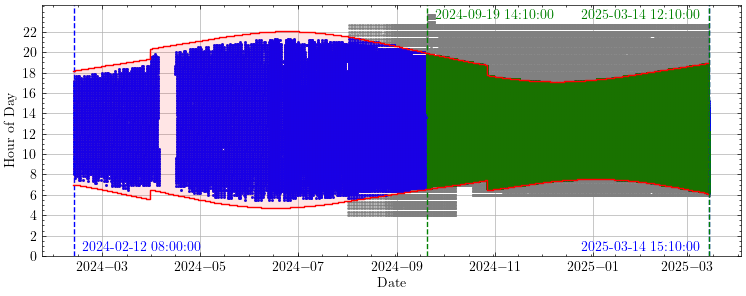

In [81]:
plt.figure(figsize=(FIG_WIDTH, 3))

# All images
plot_all = pd.DataFrame({"ts": df_all_images["timestamp"]})
plt.scatter(plot_all.ts, plot_all.ts.dt.hour + plot_all.ts.dt.minute/60, s=1, alpha=0.8, label=f"All images (SUM={len(df_all_images)})", color='gray')


# Draw total interval
plot_total = pd.DataFrame({"ts": df_total["timestamp"]})
plt.scatter(plot_total.ts, plot_total.ts.dt.hour + plot_total.ts.dt.minute/60, s=1, label=f"Images in 'total' interval (SUM={len(df_total)})", color='blue')
plt.axvline(plot_total.ts.min(), color='blue', linestyle='dashed')
plt.text(plot_total.ts.min()+pd.Timedelta(days=5), .5, plot_total.ts.min().strftime("%Y-%m-%d %H:%M:%S"), color='blue', weight='bold')
plt.axvline(plot_total.ts.max(), color='blue', linestyle='dashed')
plt.text(plot_total.ts.max()-pd.Timedelta(days=80), .5, plot_total.ts.max().strftime("%Y-%m-%d %H:%M:%S"), color='blue', weight='bold')

# Draw common interval
plot_common = pd.DataFrame({"ts": df_common["timestamp"]})
plt.scatter(plot_common.ts, plot_common.ts.dt.hour + plot_common.ts.dt.minute/60, s=1, label=f"Images in common interval (SUM={len(df_common)})", color='green')
plt.axvline(plot_common.ts.min(), color='green', linestyle='dashed')
plt.text(plot_common.ts.min()+pd.Timedelta(days=5), 23.3, plot_common.ts.min().strftime("%Y-%m-%d %H:%M:%S"), color='green', weight='heavy')
plt.axvline(plot_common.ts.max(), color='green', linestyle='dashed')#
plt.text(plot_common.ts.max()-pd.Timedelta(days=80), 23.3, plot_common.ts.max().strftime("%Y-%m-%d %H:%M:%S"), color='green', weight='heavy')

# Draw dusk & dawn container
# add daily upper lower boundary from df_total_dusk_dawn
fr_dusk_dawn = dusk_dawn_df[
    (plot_all.ts.max().date() >= dusk_dawn_df["ts"]) &
    (plot_all.ts.min().date() <= dusk_dawn_df["ts"])
]
plt.plot(fr_dusk_dawn.ts, fr_dusk_dawn.dusk.dt.hour + fr_dusk_dawn.dusk.dt.minute/60, color='red', drawstyle='steps-post', label="dusk/dawn")
plt.plot(fr_dusk_dawn.ts, fr_dusk_dawn.dawn.dt.hour + fr_dusk_dawn.dawn.dt.minute/60, color='red', drawstyle='steps-post')
plt.fill_between(fr_dusk_dawn.ts, fr_dusk_dawn.dusk.dt.hour + fr_dusk_dawn.dusk.dt.minute/60, fr_dusk_dawn.dawn.dt.hour + fr_dusk_dawn.dawn.dt.minute/60, color='red', alpha=0.1)

plt.grid(True)
plt.gca().set_axisbelow(True)

# plt.title("Unique timestamps of all images")
plt.xlabel("Date")
plt.ylabel("Hour of Day")
# format horu as int
# plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x)}"))
plt.yticks(
    np.arange(0, 24, 2),
    [f"{int(x)}" for x in np.arange(0, 24, 2)],
)

plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/over-time-common-interval.png", dpi=300)
plt.show()

# All images

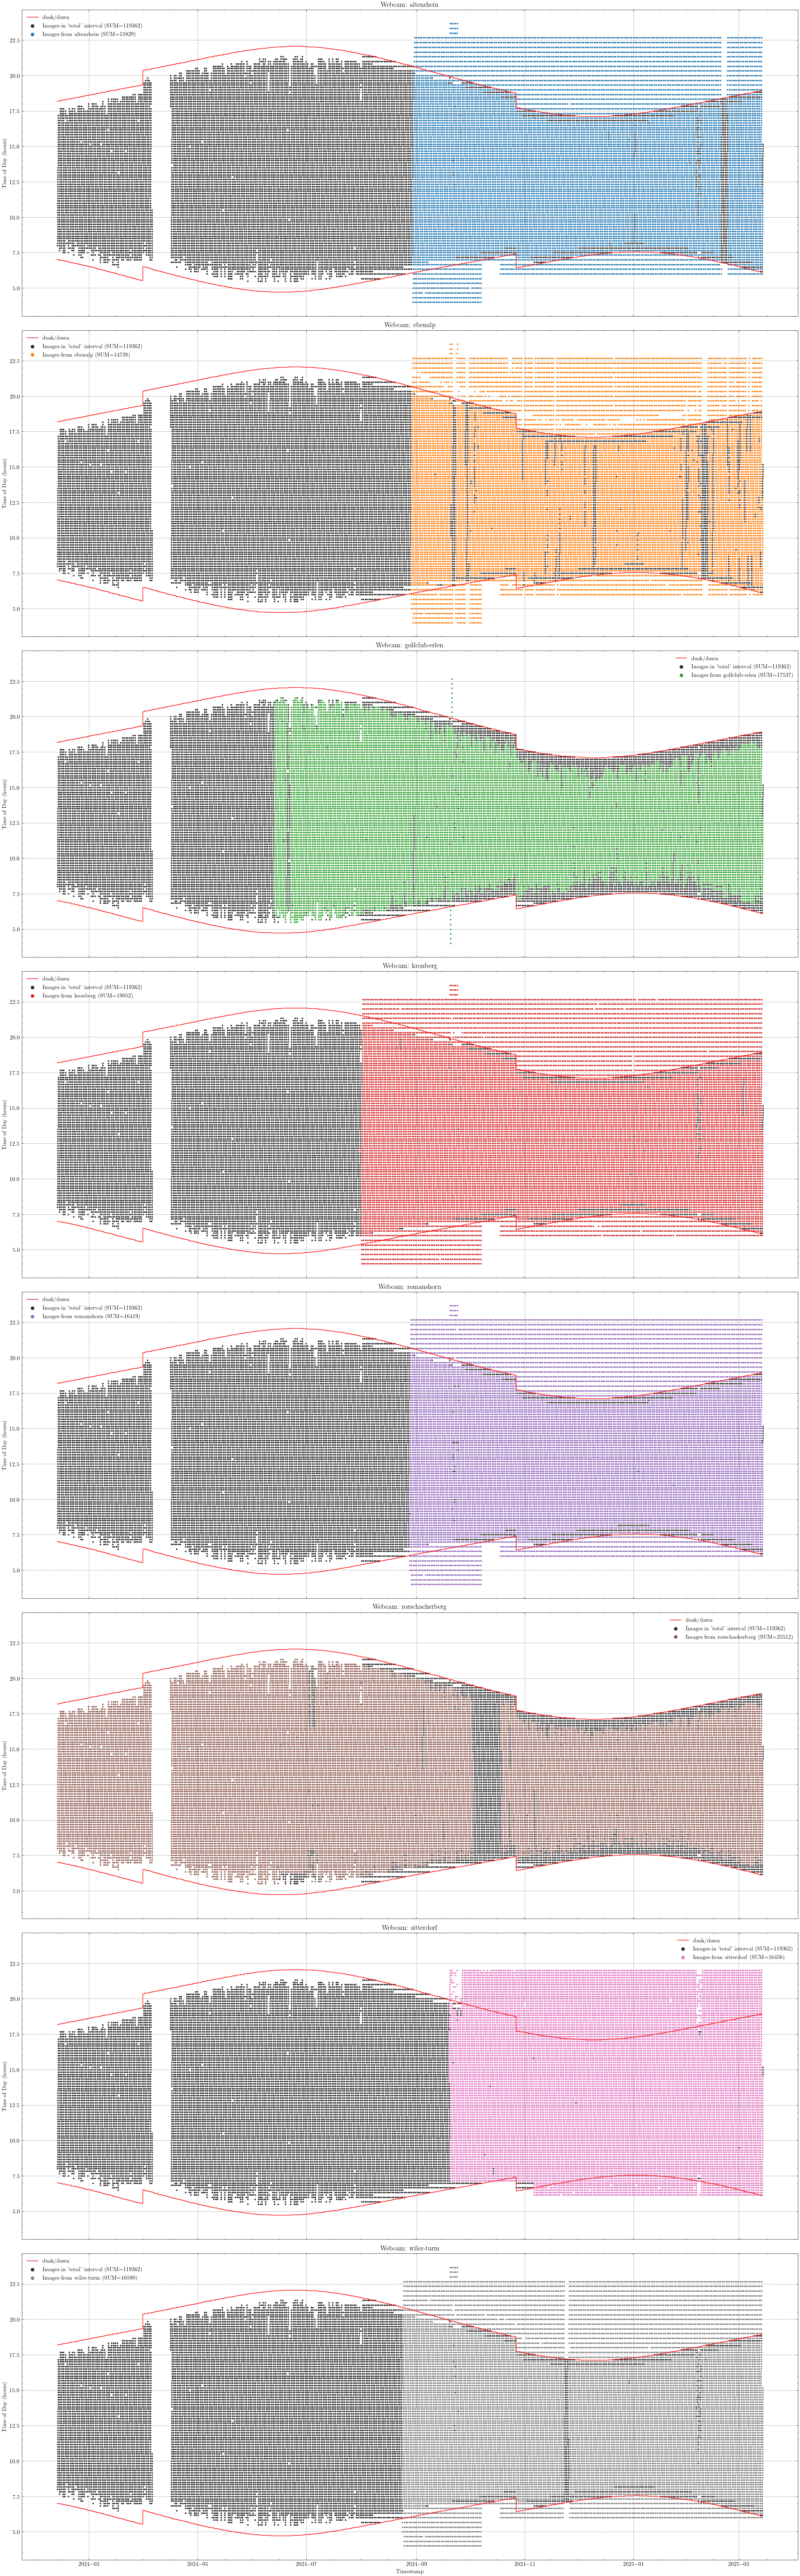

In [71]:
fig, axes = plt.subplots(len(webcams), 1, figsize=(20, 8 * len(webcams)), sharex=True, sharey=True,
                         gridspec_kw={'height_ratios': [2] * len(webcams)})

for ax, wbc in zip(axes, webcams):
    ax.plot(dusk_dawn_df.ts, dusk_dawn_df.dusk.dt.hour + dusk_dawn_df.dusk.dt.minute / 60, color='red', drawstyle='steps-post', label="dusk/dawn")
    ax.plot(dusk_dawn_df.ts, dusk_dawn_df.dawn.dt.hour + dusk_dawn_df.dawn.dt.minute / 60, color='red', drawstyle='steps-post')

    # Draw total interval
    plot_total = pd.DataFrame({"ts": df_total["timestamp"].unique()})
    plot_total = plot_total[~plot_total["ts"].isin(df_all_images[df_all_images["webcam"] == wbc].timestamp)]
    ax.scatter(
        plot_total.ts, 
        plot_total.ts.dt.hour + plot_total.ts.dt.minute/60, 
        s=3, 
        color='black', 
        alpha=0.8, 
        label=f"Images in 'total' interval (SUM={len(df_total)})"
    )

    # Draw 
    ax.scatter(
        df_all_images[df_all_images["webcam"] == wbc].timestamp, 
        df_all_images[df_all_images["webcam"] == wbc].timestamp.dt.hour + df_all_images[df_all_images["webcam"] == wbc].timestamp.dt.minute / 60, 
        s=3, 
        label=f"Images from {wbc} (SUM={len(df_all_images[df_all_images['webcam'] == wbc])})", 
        color=wbc_cmap[wbc]
    )

    ax.grid(color='gray', linestyle='dashed')
    ax.set_title(f"Webcam: {wbc}")
    ax.set_ylabel("Time of Day (hours)")
    ax.legend(markerscale=3)


axes[-1].set_xlabel("Timestamp")
plt.tight_layout()
plt.show()